This program is uses a Generative Adversial Network (GAN) to enhance the resolution of images. \
Here colored images.\
Source:\
https://arxiv.org/pdf/1609.04802.pdf - Paper\
https://www.youtube.com/watch?v=nbRkLE2fiVI - Paper's explanation\
https://www.youtube.com/watch?v=1HqjPqNglPc&t=2s - Code Explanation
 

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [6]:
def res_block(ip):

    # Function for resudial blocks used and described by the paper at page 5
    # This block is used to construct the generator
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [7]:
def upscale_block(ip):
    
    # Function that provides the upscaling block after the image has run through the residual block to gain a higher resolution
    # See paper at page 5
    # This block is used to construct the generator

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [8]:
def create_gen(gen_ip, num_res_block):

    # An GAN contains a generator and discriminator network.
    # The generator is trained and later used to enhance the quality of the image
    # This is the function that creates the generator 
    # Architecture see paper at page 5

    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)       #<-- last ouput layer that generates the enhanced image

    return Model(inputs=gen_ip, outputs=op)

In [9]:
def discriminator_block(ip, filters, strides=1, bn=True):

    # Architecture see paper at page 5
    # This block is used to construct discriminator
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [10]:
def create_disc(disc_ip):

    # A GAN consists of a generator and discriminator. 
    # The discriminator is used to detect fake images from real images => Helps the generator to increase its accurarcy in enhancing images.
    # This function creates the discriminator 


    df = 64
    
    # Architecture of discriminator as described by paper on page 5
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)  #<-- last layer that returns 0 (fake image) or 1 (real image)

    return Model(disc_ip, validity)

In [11]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

In [12]:
def build_vgg(hr_shape):

    # This function builds the VGG19 to the 10th layer

    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)     #<-- weights are predefined for image optimization
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [13]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):

    # This function creates the GAN by combining the generator and the discriminator

    gen_img = gen_model(lr_ip)      #<-- low resolution image is fed in here
    
    gen_features = vgg(gen_img)     #<-- extracts features from generator fake image
    
    disc_model.trainable = False    #<-- discriminator is not trainable here, since it should declare which image is fake and real
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

In [14]:
#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=5000
lr_list = os.listdir("image dataset/mirflickr25k/lr_images")[:n]          #<--- loads the first n paths from directory where low resolution images are saved


In [15]:
# Loads low resolution images

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("image dataset/mirflickr25k/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)        #<-- converts BGR color scheme to RGB color scheme
    lr_images.append(img_lr)   

In [16]:
# Loads the first n paths from directory where high resolution images are saved
hr_list = os.listdir("image dataset/mirflickr25k/hr_images")[:n]

In [17]:
# Loads high resolution images

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("image dataset/mirflickr25k/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

In [18]:
# Converts lists into arrays

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

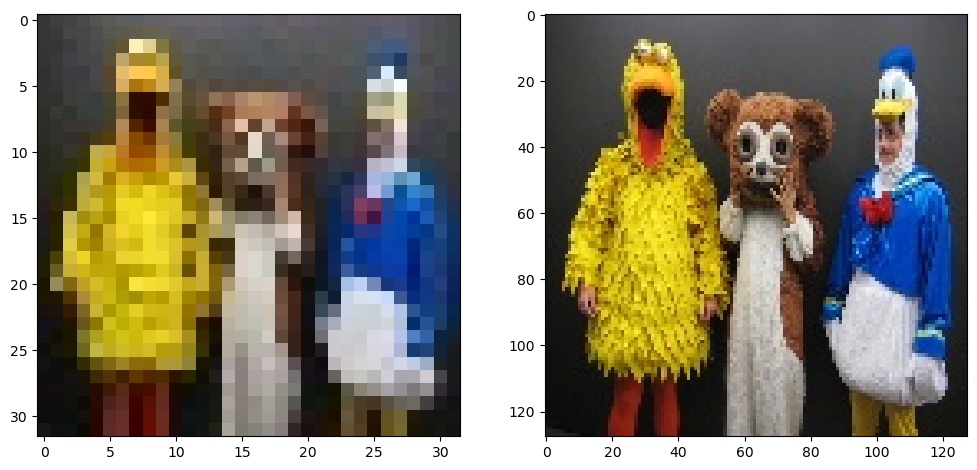

In [19]:
#Sanity check, view few mages - just for testing purposes if loading was correctly 
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [20]:
#Normalize images
lr_images = lr_images / 255.
hr_images = hr_images / 255.

In [21]:
# Determine train and test data
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)      #<-- 67% of dataset is used for training, remaining for testing

In [22]:
# Shape of image dataset
np.shape(lr_train)

(3350, 32, 32, 3)

In [23]:
# Gets the shape of low and high resolution images

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

In [24]:
# Creates input tensor for generator and discriminator

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [25]:
# Creates generator object/ model
generator = create_gen(lr_ip, num_res_block = 16)           #<-- num residual block given by paper
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 32, 32, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['p_re_lu[0][0]']             
                                                                                              

In [26]:
# Creates discriminator object/ model
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])       #<-- binary_crossentropy means that the image is either a true or false image (0,1)
discriminator.summary()                                                                         # it optimizes w.r.t. accuary

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [27]:
# Downloads VGG19 object/ model

# The VGG19 model is used to extract the features of the fake images generated by the generator and compare it to the feature the VGG19
# is able to extract from the original images. The VGG19 is used to compute the loss in features and thus helps to train the generator.
# The VGG19 is able to do that reliable, because it has been trained on million of images before. 

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False               #<-- but sets it as non-trainable

80134624/80134624 [==============================] - 15s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                           

In [28]:
# Creates the GAN object/ model, since generator, discriminator, and VGG19 models are now created

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

In [29]:
#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

# Compiles model, such that it is ready to for the training
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128, 128, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    3824928   ['model[0][0]']               
                                                          1                                 

In [30]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1                                                  #<-- batch size = 1 means, that 1 image is given to generator and discriminator at once
                                                                # one can increase the number of images supplied to gen and disc, but quality of outcome decreases
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
#  Trains the GAN

# WARNING!!!!! ONE EPOCH TAKES 14 HOURS TO COMPLETE WITH THIS HARDWARE

epochs = 1                              #<--- vanilla is 5 epochs
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

###################################################################################

In [ ]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_10.h5', compile=False)    #<-- loads saved model         

In [ ]:
# Copies image dataset from test dataset
[X1, X2] = [lr_test, hr_test]

# selects random example image
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]               #<-- here is the point where low resolution images can be loaded in for enhancing

# generate image from source
gen_image = generator.predict(src_image)

In [ ]:
# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [ ]:
################################################
###  EXAMPLE OF LOADING AN LOW RESOLUTION IMAGE AND MODEL ENHANCES IT ###
################################################


sreeni_lr = cv2.imread("data/sreeni_32.jpg")
sreeni_hr = cv2.imread("data/sreeni_256.jpg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()